#1. Import

In [ ]:
!pip install yahoo_fin
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import pandas as pd
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import jinja2

#2. Collect

In [ ]:
df = {}
df = si.get_data('NG=F')
df = pd.DataFrame(df)
df = df [['open', 'close', 'high', 'low']].round(3)
resampled_df = df.resample('1D').mean()
resampled_df.interpolate(method='linear', axis = 0, inplace= True, limit_direction='forward')
plt.show()

#3. Preliminary Analysis

In [ ]:
resampled_df.corr()

,open,close,high,low
open,1.000000,0.997654,0.998694,0.998890
close,0.997654,1.000000,0.998851,0.998907
high,0.998694,0.998851,1.000000,0.998251
low,0.998890,0.998907,0.998251,1.000000


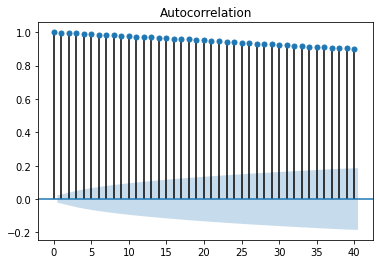

In [ ]:
stripped_resampled_df = resampled_df['close']
plot_acf(stripped_resampled_df)
plt.show()

In [ ]:
ma_resampled_df = pd.DataFrame(resampled_df['close'])
ma_resampled_df['ma180'] = resampled_df['close'].rolling(180).mean()
ma_resampled_df['ma60'] = resampled_df['close'].rolling(60).mean()
ma_resampled_df['ma30'] = resampled_df['close'].rolling(30).mean()
ma_resampled_df['std_min'] = resampled_df['close'] - resampled_df['close'].rolling(360).std()
ma_resampled_df['std_max'] = resampled_df['close'] + resampled_df['close'].rolling(360).std()



ma_resampled_df = ma_resampled_df[359:]
ma_resampled_df

,close,ma180,ma60,ma30,std_min,std_max
2001-08-24,2.706000,4.160425,3.130125,3.106800,0.996005,4.415995
2001-08-25,2.652000,4.147047,3.117708,3.090933,0.936564,4.367436
2001-08-26,2.598000,4.132092,3.107508,3.071967,0.876949,4.319051
2001-08-27,2.544000,4.117086,3.095325,3.049133,0.817098,4.270902
2001-08-28,2.420000,4.101725,3.084058,3.020100,0.686716,4.153284
...,...,...,...,...,...,...
2022-08-05,8.064000,6.626961,7.276575,7.597000,6.526080,9.601920
2022-08-06,7.905667,6.647370,7.253453,7.650622,6.365469,9.445864
2022-08-07,7.747333,6.666811,7.237592,7.707733,6.205934,9.288732
2022-08-08,7.589000,6.686700,7.214692,7.755211,6.047273,9.130727


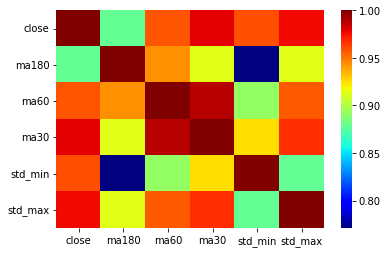

In [ ]:
import seaborn as sns

sns.heatmap(ma_resampled_df.corr(), cmap='jet')

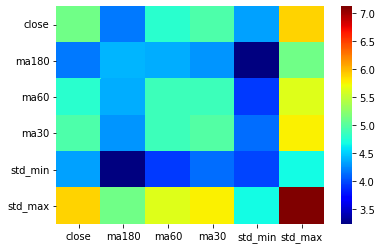

In [ ]:
sns.heatmap(ma_resampled_df.cov(), cmap='jet')

In [ ]:
ma_monthly_resampled_df = ma_resampled_df.resample('1M').mean()

In [ ]:
ma_monthly_resampled_df['close']

2001-08-31    2.504375
2001-09-30    2.285450
2001-10-31    2.621000
2001-11-30    2.803333
2001-12-31    2.715484
                ...   
2022-04-30    6.721633
2022-05-31    8.117871
2022-06-30    7.597100
2022-07-31    7.132629
2022-08-31    7.945111
Freq: M, Name: close, Length: 253, dtype: float64

#4. Sentiment Analyser

In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textblob import TextBlob
plt.style.use('fivethirtyeight')

## a. KEYWORD

In [ ]:
keyword = {"keyw": "Natural Gas","asset": 'commodity'}

if keyword['asset'] == 'stocks':
  keyword['scrape_search'] = keyword['keyw'] + ' shares'
else:
  keyword['scrape_search'] = keyword['keyw'] + ' prices'

## b. Scrapper

In [ ]:
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen
import datetime
import pandas as pd

def webCrawl (search):
    news_df = pd.DataFrame(columns={"Headline", "Date_time", "URL"})
    date = datetime.datetime.now()
    date = date.date() - datetime.timedelta(days=1500)
    date = str(date)
    date = date.replace("-", "")
    date = int(date)
    search = search.replace(" ", "%20")
    search = search.replace("Limited", "")
    search = search.replace("ltd", "")
    search = search.replace("INC", "")
    search = search.replace("inc", "")
    search = search.replace("LLC", "")
    newsUrl = "https://news.google.com/rss/?q=" + str(search)
    website = urlopen(newsUrl)
    xml_page = website.read()
    website.close()
    ret_n = pd.DataFrame(columns=[""])
    soup_page = soup(xml_page, "xml")
    news_list = soup_page.findAll("item")
    # Print news title, url and publish date
    for news in news_list:
        day = (news.pubDate.text[5:7])
        wkday = str(news.pubDate.text[0:4])
        pub_time = str(news.pubDate.text[17:25])
        d = {"Jan" : "01", "Feb" : "02", "Mar" : "03", "Apr" : "04", "May" : "05", "Jun" : "06", "Jul" : "07", "Aug" : "08", "Sep" : "09", "Oct" : "10", "Nov" : "11", "Dec" : "12"}
        month = (d.get(news.pubDate.text[8:11]))
        year = (news.pubDate.text[12:16])
        date_t = str(year + "-" + month + "-" + day + " " +pub_time)
        format = "%Y-%m-%d %H:%M:%S"
        date_time = datetime.datetime.strptime(date_t, format) + datetime.timedelta(minutes = 330)
        date_time = wkday + str(date_time)
        date_a = int(str(year + month + day))

        if (date_a >= date):
            headl = news.title.text
            newslink = news.link.text
            news_df = news_df.append({"Headline": headl, "Date_time" : date_time, "URL": newslink}, ignore_index=True)
    return news_df 

print(webCrawl ('Amazon'))


                                             Headline  \
0   Amazon Adds Another Popular Smart Home Brand t...   
1   Impress With These Amazon Furniture and Decor ...   
2   Amazon Warehouse Walkouts Over Pay Seen Spread...   
3   Amazon Fire 7 Tablet (2022) Review: Weak but C...   
4   'A very strong accelerant': Amwell CEO shares ...   
..                                                ...   
95  It’s now easier for sellers to manage their mo...   
96  Amazon, 3M file lawsuit alleging counterfeit r...   
97  Amazon offers to limit use of merchant data in...   
98  Amazon faces probe by federal prosecutors and ...   
99  Amazon gave Ring videos to police without owne...   

                  Date_time                                                URL  
0   Tue,2022-08-09 19:06:39  https://www.kiplinger.com/personal-finance/sho...  
1   Tue,2022-08-09 23:15:00  https://theinventory.com/impress-with-these-am...  
2   Tue,2022-08-09 22:27:00  https://www.bloomberg.com/news/articles/202

#5. Data Augment

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# monthly_resampled_df = ma_resampled_df.resample('1M').mean()
# plt.plot(monthly_resampled_df['close'] ,label = 'close')
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
def root(x):
  return math.sqrt(x)

In [ ]:
rows, attributes = ma_resampled_df.shape

months = 48 * 30

scaler_mod = scaler.fit(ma_resampled_df)
scaler_mean = list(map(np.float32, scaler.mean_))
scaler_var = list(map(np.float32,scaler.scale_))
print(list(map(np.float32, scaler_mean)))
print(list(map(np.float32, scaler_var)))
monthly_resampled_df_scaled = scaler.transform (ma_resampled_df)
train_monthly_resampled_df = monthly_resampled_df_scaled[0:(rows-months)]
test_monthly_resampled_df = monthly_resampled_df_scaled[(rows-months):]

print(train_monthly_resampled_df.shape, test_monthly_resampled_df.shape) 


[4.5216045, 4.4793324, 4.5048733, 4.5122437, 3.6909397, 5.3522696]
[2.2626767, 2.1018696, 2.208127, 2.2344203, 1.9983234, 2.6669602]
(6216, 6) (1440, 6)


In [ ]:
for rowIndex, row in enumerate(monthly_resampled_df):
  print(row)
  break

close


In [ ]:
def batch_gen(df):
  batch_size = 180
  validation_size = 60
  X = []
  Y = []
  for i in range(180, df.shape[0]-60):
    X.append(df[i-180:i])
    Y.append([x[0] for x in df[i:i+60]])

  Y = np.array(Y)
  X = np.array(X)
  return X ,Y


batch_X_monthly_df_train, batch_Y_monthly_df_train = batch_gen(train_monthly_resampled_df)


print(f'Shape of Training Data: {batch_X_monthly_df_train.shape}')
print(f'Shape of Testing Data: {batch_Y_monthly_df_train.shape}')

Shape of Training Data: (5976, 180, 6)
Shape of Testing Data: (5976, 60)


In [ ]:
batch_X_monthly_df_train[:45]

array([[[-0.80241455, -0.15172558, -0.6225857 , -0.62899705,
         -1.34859776, -0.35106449],
        [-0.82628009, -0.15809029, -0.62820887, -0.63609807,
         -1.37834323, -0.36927208],
        [-0.85014563, -0.16520564, -0.63282817, -0.64458647,
         -1.40817577, -0.38741443],
        ...,
        [-0.98162707, -0.94335481, -0.99146356, -1.05771002,
         -1.23422468, -0.74085446],
        [-0.96074472, -0.94466912, -0.99401663, -1.05562894,
         -1.20910806, -0.72424047],
        [-0.93986237, -0.94576867, -0.99779057, -1.05242901,
         -1.18397026, -0.70764234]],

       [[-0.82628009, -0.15809029, -0.62820887, -0.63609807,
         -1.37834323, -0.36927208],
        [-0.85014563, -0.16520564, -0.63282817, -0.64458647,
         -1.40817577, -0.38741443],
        [-0.87401116, -0.17234479, -0.63834566, -0.65480538,
         -1.43812643, -0.40546828],
        ...,
        [-0.96074472, -0.94466912, -0.99401663, -1.05562894,
         -1.20910806, -0.72424047],
  

#6. LSTM


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LeakyReLU
from tensorflow import keras
import os

In [ ]:
models_folder = '/content/drive/MyDrive/Models'
model_version = len(os.listdir(models_folder)) + 1
model_version

4

## a. Model Compilation

In [ ]:
model = Sequential()

model.add(LSTM(50, activation=LeakyReLU(alpha=0.001), input_shape=(batch_X_monthly_df_train.shape[1], batch_X_monthly_df_train.shape[2]), return_sequences=True))

model.add(LSTM(50, activation=LeakyReLU(alpha=0.001), return_sequences=True))

model.add(LSTM(50, activation=LeakyReLU(alpha=0.001), return_sequences=False))
model.add(Dropout(0.20))

model.add(Dense(batch_Y_monthly_df_train.shape[1]))
model.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 180, 50)           11400     
                                                                 
 lstm_40 (LSTM)              (None, 180, 50)           20200     
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 60)                3060      
                                                                 
Total params: 54,860
Trainable params: 54,860
Non-trainable params: 0
_________________________________________________________________


## b. Model Fitting

In [ ]:
history = model.fit(batch_X_monthly_df_train, batch_Y_monthly_df_train, epochs=100, batch_size = 32, validation_split=0.2 , verbose = 1, callbacks=[early_stopping])

Epoch 1/100
150/150 [==============================] - 44s 265ms/step - loss: 90.4688 - val_loss: 0.7128
Epoch 2/100
150/150 [==============================] - 39s 260ms/step - loss: nan - val_loss: nan
Epoch 3/100
 13/150 [=>............................] - ETA: 35s - loss: nan

KeyboardInterrupt: ignored

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.plot(history.history['loss'][20:], label='Training loss', c='orange')
ax2.plot(history.history['val_loss'][20:], label='Validation loss' , c = 'green')
fig.legend()
fig.show()

In [ ]:
batch_Y_monthly_df_test , batch_X_monthly_df_test = batch_gen(test_monthly_resampled_df)
print(f'Shape of Testing Data: {batch_X_monthly_df_test.shape}')
print(f'Shape of Validating Data: {batch_Y_monthly_df_test.shape}')



In [ ]:
pred_data = batch_X_monthly_df_test[0]

result = []

for i in range(0, 36):
  res = model.predict(np.array([pred_data]))[0,0]
  res = (res * scaler_var[0]) + scaler_mean[0]
  result.append(res)
  pred_data = scaler.inverse_transform(pred_data)
  res_30 = res
  res_60 = sum([*pred_data[-2:,2] , res])/4
  res_180 = sum([*pred_data[-5:,2] , res])/8
  pred_data = list(pred_data)
  pred_data.append(np.array([res, res_30, res_60, res_180]))
  pred_data.pop(0)
  pred_data = np.array(pred_data)
  pred_data = scaler.transform(pred_data)

# print(result)

In [ ]:
test_monthly_resampled_df_unscaled = scaler.inverse_transform(test_monthly_resampled_df)
print(result[:])
plt.plot(result[:], label='Predictions', c='green')
plt.plot(test_monthly_resampled_df_unscaled[12:, 0], label='Observed' , c = 'orange')
plt.legend()
plt.show()

## c. Model Save

In [ ]:
save_model = str(input('Do you want to save model[y/n]: '))
if save_model.lower() != 'n':
  model.save(f'/content/drive/MyDrive/Models/Model_V{model_version}')

